In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:

from datetime import datetime


# Read the data
data = pd.read_csv('exchange-rate-twi.csv')
data.columns = ['Month', 'Exchange Rate TWI']

# Drop rows with missing values if any
data = data.dropna()

# Total number of months
n_months = len(data)

# Generate a date range ending in the current month, going back n_months
end_date = pd.to_datetime(datetime.now().replace(day=1),format='%Y-%m')  # e.g., 2025-05-01
date_range = pd.date_range(end=end_date, periods=n_months, freq='MS')  # MS = Month Start

# Replace 'Month' column with proper datetime
data['Month'] = date_range

# Set datetime index
data = data.set_index('Month')
# removing the time component 
data.index = data.index.normalize()
data.head()



,Exchange Rate TWI
Month,
2000-02-01,100.0
2000-03-01,99.6
2000-04-01,99.4
2000-05-01,99.1
2000-06-01,99.2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2000-02-01 to 2025-05-01
Freq: MS
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Exchange Rate TWI  304 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


## Time Series Analysis

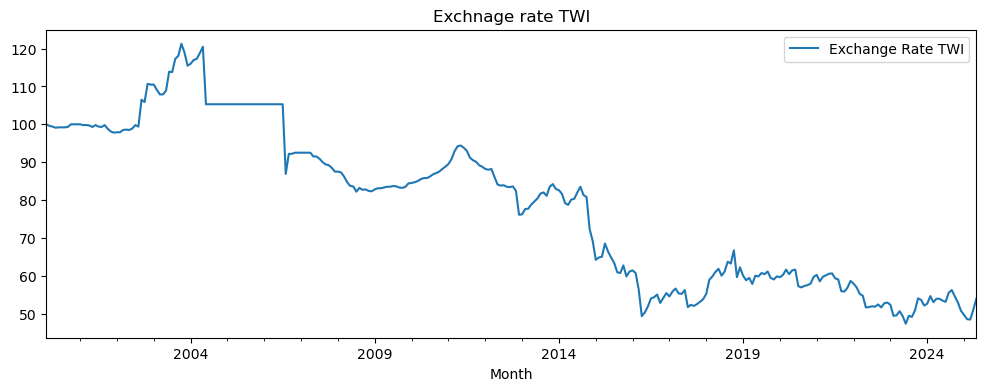

In [5]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Exchnage rate TWI')
plt.show(block=False)

## Outlier Detection

### box plot and interquartile range

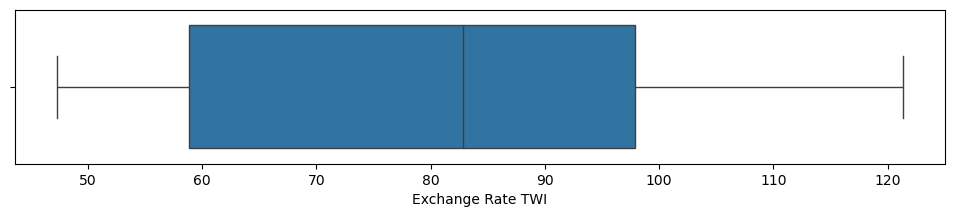

In [8]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Exchange Rate TWI'],whis=1.5)
plt.show()

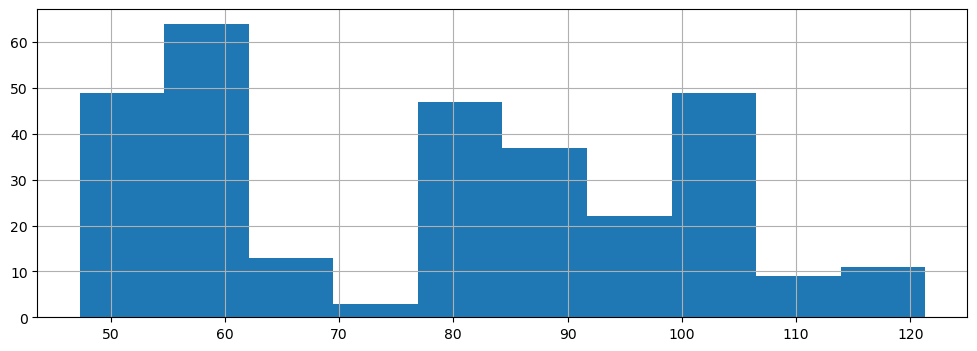

In [9]:
fig = data['Exchange Rate TWI'].hist(figsize=(12, 4))
plt.show()

## Time series Decomposition

### additive seasonal decompositon 

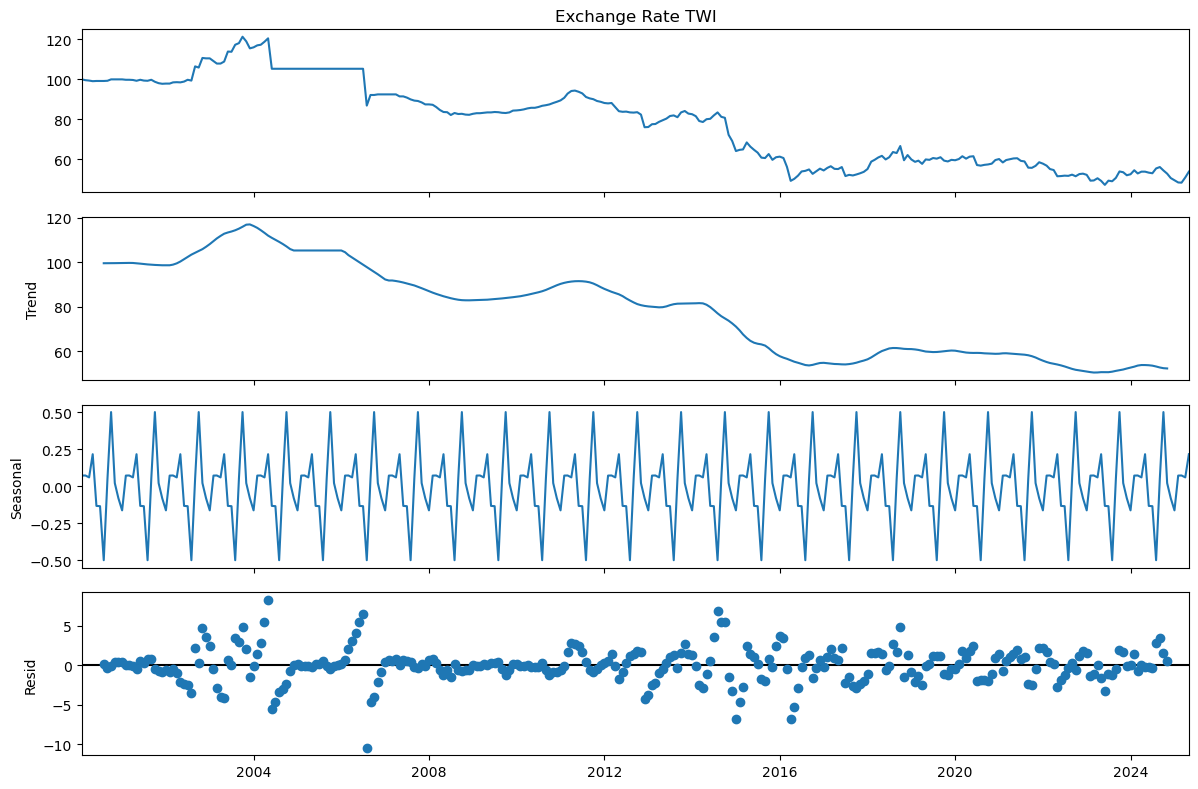

In [12]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data['Exchange Rate TWI'], model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### multiplicative seasonal decomposition 

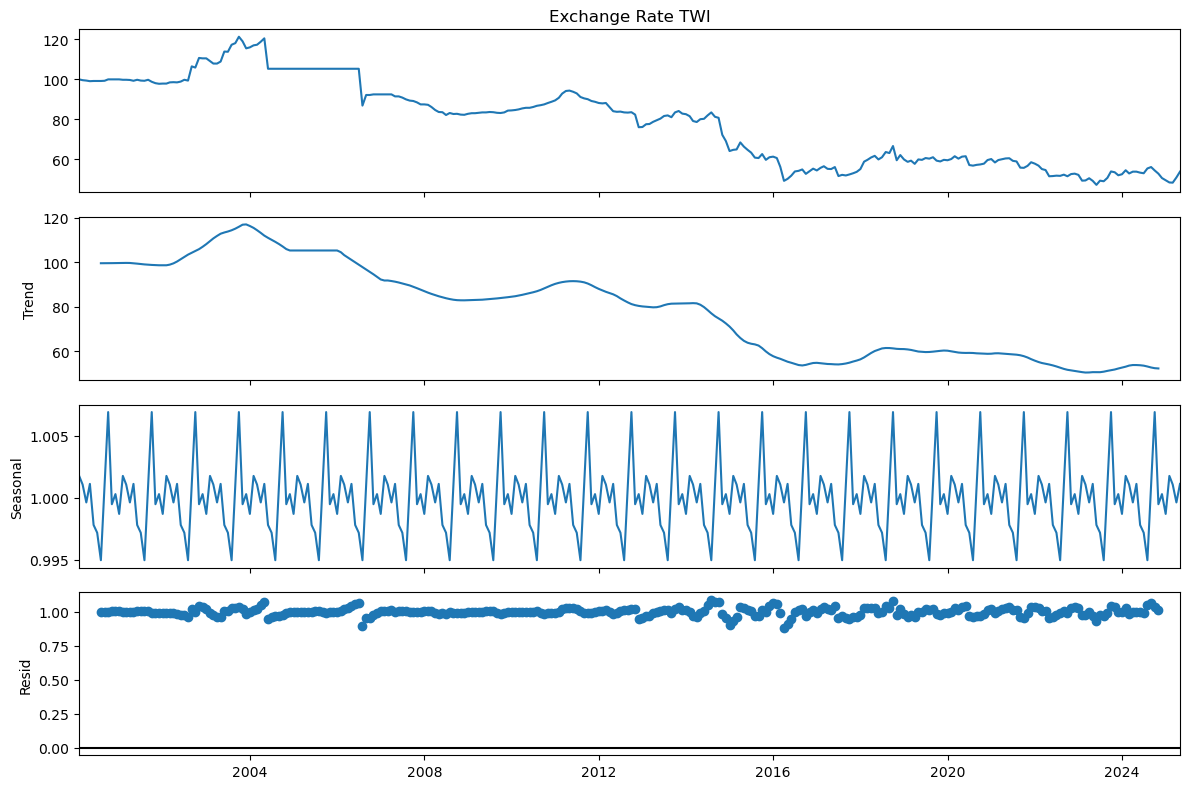

In [14]:
decomposition = sm.tsa.seasonal_decompose(data['Exchange Rate TWI'], model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

## Build and evaluate time series forecast

### Split time series data into training and test set

In [17]:
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

### naive method

In [19]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Exchange Rate TWI'][train_len-1]

### plot train test and forcast 

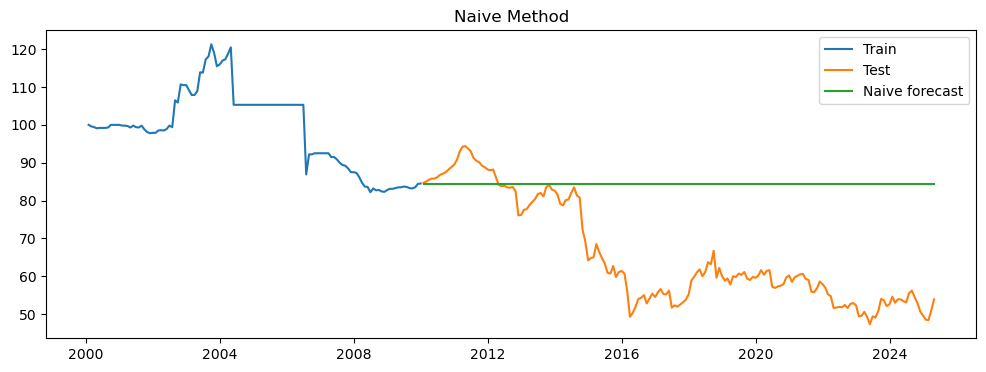

In [21]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [23]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_naive['naive_forecast'])/test['Exchange Rate TWI'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,23.48,35.72


## Simple average method

In [25]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Exchange Rate TWI'].mean()

### Plot train, test and forecast

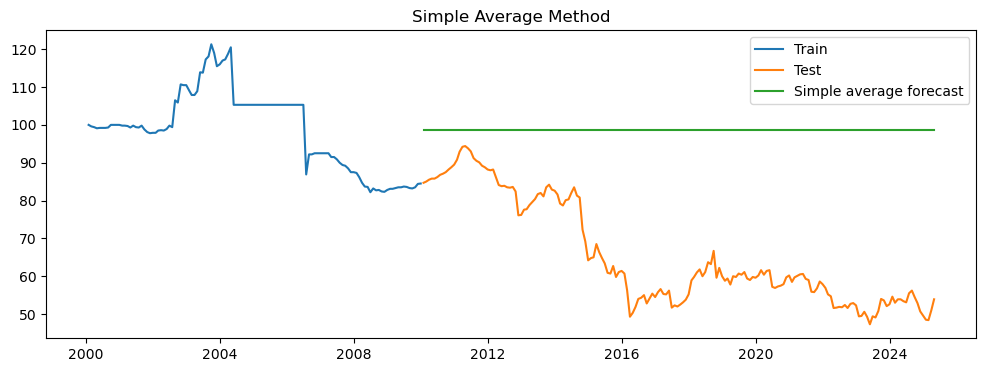

In [27]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [28]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_avg['avg_forecast'])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,23.48,35.72
0,Simple average method,35.91,56.80


## Simple moving average method

In [30]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Exchange Rate TWI'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

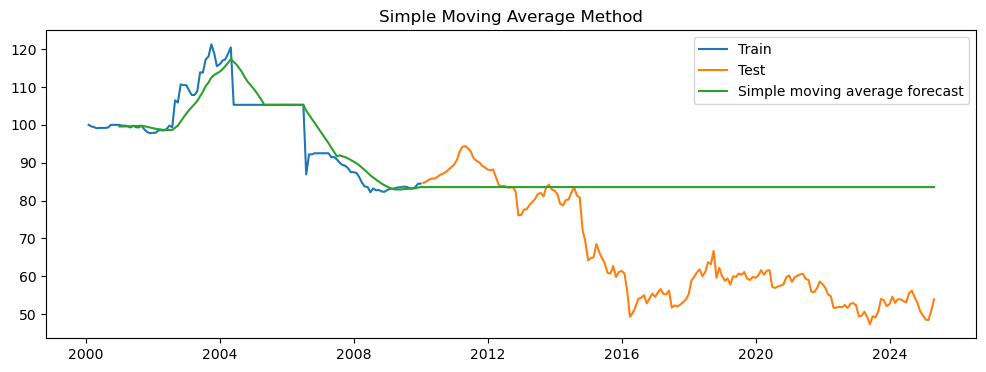

In [31]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [32]:
## calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_sma['sma_forecast'][train_len:])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,23.48,35.72
0,Simple average method,35.91,56.80
0,Simple moving average forecast,22.72,34.56


## Exponential smoothing methods

### Simple Eponential smoothing

In [35]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Exchange Rate TWI'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
forecast = model_fit.forecast(len(test))
forecast.index = test.index
y_hat_ses['ses_forecast'] = forecast
#  why we use forcast.index : Index Alignment-
# test has a date-based index (like monthly dates). Assigning forecast.index = test.index ensures:
# forecast matches the time periods of test
# Pandas can align values row-by-row correctly
# Without it, you'll get:
# Misaligned forecast values
#Potentially NaNs or mismatches in evaluation metrics like RMSE, MAPE



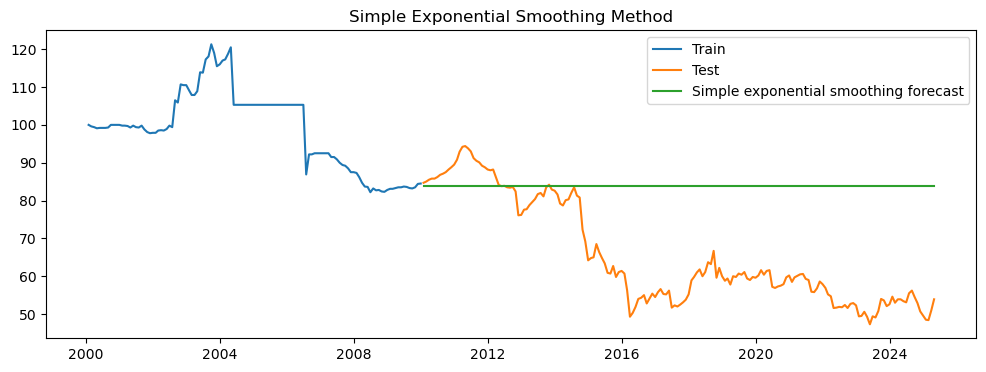

In [36]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [37]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_ses['ses_forecast'])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,23.48,35.72
0,Simple average method,35.91,56.80
0,Simple moving average forecast,22.72,34.56
0,Simple exponential smoothing forecast,22.90,34.83


## Holt's method with trend

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Exchange Rate TWI']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 99.4133333333333, 'initial_trend': 0.015757575757584658, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### ploting train, test and forcast

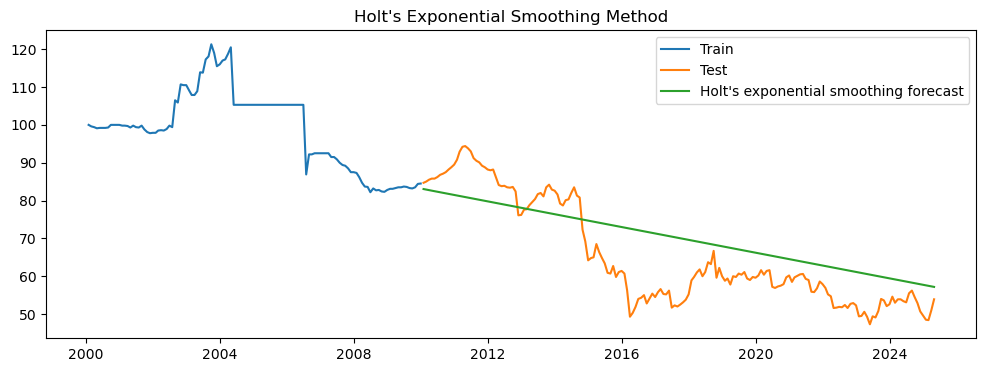

In [41]:
plt.figure(figsize=(12,4))
plt.plot( train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### calculating RMSE and MAPE

In [43]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_holt['holt_forecast'])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,23.48,35.72
0,Simple average method,35.91,56.80
0,Simple moving average forecast,22.72,34.56
0,Simple exponential smoothing forecast,22.90,34.83
0,Holt's exponential smoothing method,9.37,13.62


### Holt Winters' additive method with trend and seasonality

In [45]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Exchange Rate TWI']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)

# Forecasting
forecast = model_fit.forecast(len(test))

# Align the forecast with the index of the test set
forecast = pd.Series(forecast, index=test.index)

# Add the forecast to the y_hat_hwa DataFrame
y_hat_hwa = test.copy()
y_hat_hwa['hw_forecast'] = forecast

{'smoothing_level': 0.8639570293112097, 'smoothing_trend': 7.45189466798742e-09, 'smoothing_seasonal': 1.647345259561544e-09, 'damping_trend': nan, 'initial_level': 99.72550656057071, 'initial_trend': -0.12951941822282004, 'initial_seasons': array([ 0.36944687,  0.31886369,  0.44840943,  0.58798684, -0.21248088,
       -0.22297316, -1.63344957, -0.2639443 ,  0.07564026,  0.33523916,
        0.0447455 ,  0.29419671]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

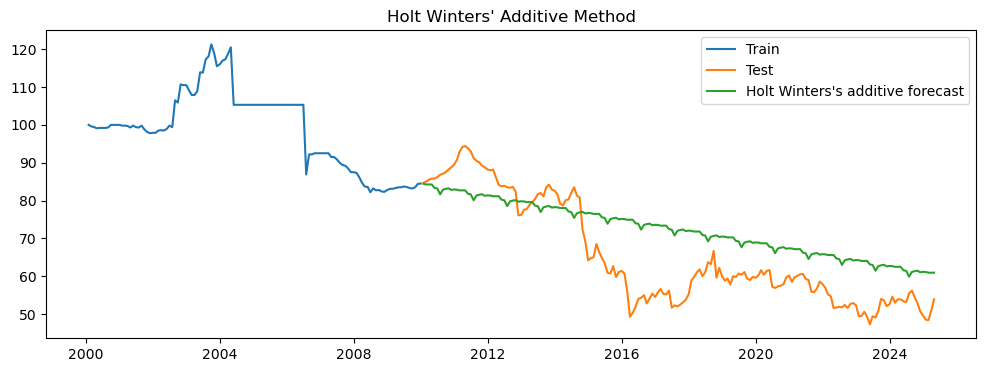

In [47]:
plt.figure(figsize=(12,4))
plt.plot( train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculating RMSE And MAPE

In [49]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_hwa['hw_forecast'])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,23.48,35.72
0,Simple average method,35.91,56.80
0,Simple moving average forecast,22.72,34.56
0,Simple exponential smoothing forecast,22.90,34.83
0,Holt's exponential smoothing method,9.37,13.62
0,Holt Winters' additive method,10.88,16.26


## Holt Winter's multiplicative method with trend and seasonality

In [51]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Exchange Rate TWI']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
forecast = model_fit.forecast(len(test))
# Align the forecast with the index of the test set
forecast = pd.Series(forecast, index=test.index)
# Add the forecast to the y_hat_hwa DataFrame
y_hat_hwm = test.copy()
y_hat_hwm['hw_forecast'] = forecast

{'smoothing_level': 0.8602031241818596, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.0, 'damping_trend': nan, 'initial_level': 97.57717062747345, 'initial_trend': -0.1266291969241834, 'initial_seasons': array([1.02576069, 1.02544285, 1.02734236, 1.02954696, 1.01870946,
       1.01924677, 1.00411692, 1.01875545, 1.0230673 , 1.02576166,
       1.02214407, 1.02486285]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


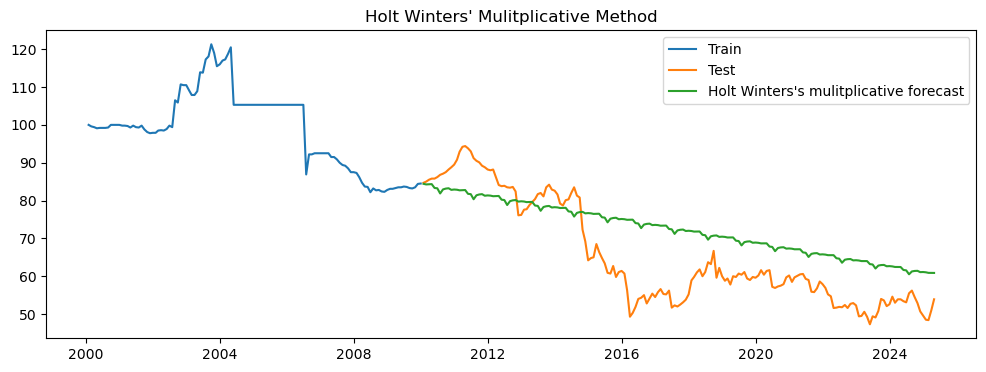

In [52]:
plt.figure(figsize=(12,4))
plt.plot( train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [53]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_hwm['hw_forecast'])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,23.48,35.72
0,Simple average method,35.91,56.80
0,Simple moving average forecast,22.72,34.56
0,Simple exponential smoothing forecast,22.90,34.83
0,Holt's exponential smoothing method,9.37,13.62
0,Holt Winters' additive method,10.88,16.26
0,Holt Winters' multiplicative method,10.90,16.31


### After evaluating multiple forecasting methods on the Exchange Rate TWI dataset using RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error), we observe the following:

1. Holt's Exponential Smoothing method outperformed all others, achieving the lowest RMSE (9.37) and lowest MAPE (13.62%), indicating it captures both level and trend effectively without seasonal adjustment.

2. Both Holt-Winters Additive and Multiplicative methods also performed well, with similar error metrics, suggesting that seasonality plays a role but is less dominant than trend in this dataset.

3. Traditional methods like the Naive, Simple Average, and Simple Moving Average produced significantly higher error values, indicating they are less suitable for this time series.

4Simple Exponential Smoothing, while better than basic methods, was not sufficient to capture the trend and/or seasonality.